## Data Science Task

##### Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


/Users/akosaraju/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
customers_df = pd.read_csv("/Users/akosaraju/Desktop/DSprojects/liberont/customers_updated.csv") #replace this with your current directory
products_df = pd.read_csv("/Users/akosaraju/Desktop/DSprojects/liberont/products_updated.csv")
purchases_df = pd.read_csv("/Users/akosaraju/Desktop/DSprojects/liberont/purchases_updated.csv")

In [3]:
print("customers df:")
print(customers_df.head())

print("\nproducts df:")
print(products_df.head())

print("\npurchases df:")
print(purchases_df.head())

customers df:
  customer_id  age  gender region signup_date
0    CUST0001   58    Male  Tokyo  2021-08-02
1    CUST0002   48  Female  Tokyo  2018-08-17
2    CUST0003   34  Female  Tokyo  2018-02-21
3    CUST0004   27    Male  Tokyo  2022-02-27
4    CUST0005   40  Female  Osaka  2019-07-18

products df:
  product_id     category  price product_name
0   PROD0001         Food   7666     PROD0001
1   PROD0002     Clothing  13482     PROD0002
2   PROD0003  Electronics  41197     PROD0003
3   PROD0004         Food  38615     PROD0004
4   PROD0005     Clothing   7769     PROD0005

purchases df:
  purchase_id customer_id product_id               purchase_date  quantity
0    PUR00001    CUST0850   PROD0189  2024-05-14 05:16:34.158693         5
1    PUR00002    CUST0911   PROD0068  2023-12-12 05:16:34.158693         4
2    PUR00003    CUST0819   PROD0104  2024-07-23 05:16:34.158693         2
3    PUR00004    CUST0141   PROD0080  2024-10-03 05:16:34.158693         4
4    PUR00005    CUST0083   PR

In [4]:

# missing values
print("\ncustomers:")
print(customers_df.isnull().sum())

print("\nproducts:")
print(products_df.isnull().sum())

print("\npurchases:")
print(purchases_df.isnull().sum())


customers:
customer_id    0
age            0
gender         0
region         0
signup_date    0
dtype: int64

products:
product_id      0
category        0
price           0
product_name    0
dtype: int64

purchases:
purchase_id      0
customer_id      0
product_id       0
purchase_date    0
quantity         0
dtype: int64


In [5]:

# data types
print("\ncustomers:")
print(customers_df.dtypes)

print("\nproducts:")
print(products_df.dtypes)

print("\npurchases:")
print(purchases_df.dtypes)


customers:
customer_id    object
age             int64
gender         object
region         object
signup_date    object
dtype: object

products:
product_id      object
category        object
price            int64
product_name    object
dtype: object

purchases:
purchase_id      object
customer_id      object
product_id       object
purchase_date    object
quantity          int64
dtype: object


In [6]:

# date columns to datetime
customers_df['signup_date'] = pd.to_datetime(customers_df['signup_date'])
purchases_df['purchase_date'] = pd.to_datetime(purchases_df['purchase_date'])


In [7]:

# duplicates
print("duplicates in customers:", customers_df.duplicated().sum())
print("duplicates in products:", products_df.duplicated().sum())
print("duplicates in purchases:", purchases_df.duplicated().sum())

# null values
print("null values in customers:\n", customers_df.isnull().sum())
print("null values in products:\n", products_df.isnull().sum())
print("null values in purchases:\n", purchases_df.isnull().sum())

duplicates in customers: 0
duplicates in products: 0
duplicates in purchases: 0
null values in customers:
 customer_id    0
age            0
gender         0
region         0
signup_date    0
dtype: int64
null values in products:
 product_id      0
category        0
price           0
product_name    0
dtype: int64
null values in purchases:
 purchase_id      0
customer_id      0
product_id       0
purchase_date    0
quantity         0
dtype: int64



#### Data preprocessing and feature engineering

first we need to define what we consider to be a churn

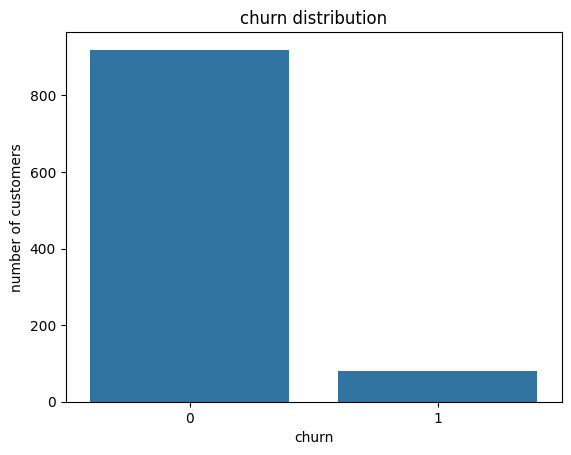

churn rate: 8.10%


In [8]:

# reference date
reference_date = purchases_df['purchase_date'].max() + pd.DateOffset(days=1)
# last purchase date per customer
last_purchase = purchases_df.groupby('customer_id')['purchase_date'].max().reset_index()
last_purchase.rename(columns={'purchase_date': 'last_purchase_date'}, inplace=True)
# merge last purchase date with customers dataframe on customer id
data = customers_df.merge(last_purchase, on='customer_id', how='left')

data['recency_days'] = (reference_date - data['last_purchase_date']).dt.days
# customers with no purchases, recency is the tenure since signup
data['recency_days'].fillna((reference_date - data['signup_date']).dt.days, inplace=True)
inactivity_period = 180  # days
data['churn'] = np.where(data['recency_days'] > inactivity_period, 1, 0)

# churn distribution 
sns.countplot(x='churn', data=data)
plt.title('churn distribution')
plt.xlabel('churn')
plt.ylabel('number of customers')
plt.show()

churn_percentage = data['churn'].mean() * 100
print(f"churn rate: {churn_percentage:.2f}%")

so here 1 indicates whether a customer has churned and 0 is if they have not. We see that there are significantly more zeroes than ones. This means that most customers have not churned over churning 

In [9]:

# we want to get product prices and categories
purchases_merged = purchases_df.merge(products_df[['product_id','category','price']], 
                                      on='product_id', 
                                      how='left')

# features
customer_agg = (
    purchases_merged
    .groupby('customer_id')
    .agg(
        total_purchases=('purchase_id', 'count'),     # purchase frequency
        total_spend=('price', 'sum'),                 # total spent by the customer
        avg_spend=('price', 'mean'),                  # avg spend per purchase
        unique_categories=('category', 'nunique'),    # different categories purchased
        first_purchase_date=('purchase_date', 'min'), # first purchase date 
        last_purchase_date=('purchase_date', 'max')   # most recent purchase date
    )
    .reset_index()
)
# if a customer never made a purchase, they won't appear in customer_agg.

# merge aggregation into customers_df on customer id
data = customers_df.merge(customer_agg, on='customer_id', how='left')

# customers with no purchases - total_purchases etc. will be NaN. 
# we saw in our data preprocessing that there were no nulls in the datasets, but merging on the left might introduce them for non-buyers so we fill them
data[['total_purchases','total_spend','avg_spend','unique_categories']] = \
    data[['total_purchases','total_spend','avg_spend','unique_categories']].fillna(0)
# last_purchase_date = signup_date and first_purchase_date = signup_date
data['last_purchase_date'] = data['last_purchase_date'].fillna(data['signup_date'])
data['first_purchase_date'] = data['first_purchase_date'].fillna(data['signup_date'])

# we define reference_date for churn calculations as max purchase_date + 1 months)
reference_date = purchases_df['purchase_date'].max() + pd.DateOffset(months=1)
# customer recency: days since last purchase
data['recency_days'] = (reference_date - data['last_purchase_date']).dt.days
# customertenure: how long the customer has been a customer
data['tenure_days'] = (reference_date - data['signup_date']).dt.days
# purchase frequency: purchases per day of tenure
data['purchase_frequency'] = data['total_purchases'] / (data['tenure_days'] + 1) 

# put age into categories
data['age_group'] = pd.cut(
    data['age'], 
    bins = [0, 17, 24, 34, 44, 54, 64, 100],
    labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'] # can teenagers afford luxury items? 
)

# churn = if recency_days > inactivity_period
inactivity_period = 180 # can change this depending on whats needed
data['churn'] = (data['recency_days'] > inactivity_period).astype(int)

print("dataset shape:", data.shape)
print(data.head(10))

dataset shape: (1000, 16)
  customer_id  age  gender   region signup_date  total_purchases  total_spend  \
0    CUST0001   58    Male    Tokyo  2021-08-02              7.0     235039.0   
1    CUST0002   48  Female    Tokyo  2018-08-17              3.0      77181.0   
2    CUST0003   34  Female    Tokyo  2018-02-21              5.0     121372.0   
3    CUST0004   27    Male    Tokyo  2022-02-27              3.0      59393.0   
4    CUST0005   40  Female    Osaka  2019-07-18              5.0     135420.0   
5    CUST0006   58  Female   Nagoya  2019-05-17              6.0      98744.0   
6    CUST0007   38    Male  Fukuoka  2019-04-03              4.0      63023.0   
7    CUST0008   42  Female    Tokyo  2018-10-13              6.0     142153.0   
8    CUST0009   30  Female    Tokyo  2022-02-17              3.0      54057.0   
9    CUST0010   30  Female    Tokyo  2018-07-29              6.0     163100.0   

      avg_spend  unique_categories        first_purchase_date  \
0  33577.000000  

So right now, we have our customer demographics(so looking at age, gender, region and sign_up date). We also have transaction based features so total_purchases, total_spend, avg_spend, unique_categories, recency_days. We have derived features so tenure_days, purchase_frequency, age_group and our target variable is churn.

In [10]:
# modeling features
feature_cols = ['age', 'gender', 'region', 'total_purchases', 'total_spend',
                'avg_spend', 'unique_categories', 'tenure_days', 
                'purchase_frequency', 'recency_days', 'age_group']

X = data[feature_cols]
y = data['churn']

# 80-20 train/test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)
print(X_train.columns)

Index(['age', 'gender', 'region', 'total_purchases', 'total_spend',
       'avg_spend', 'unique_categories', 'tenure_days', 'purchase_frequency',
       'recency_days', 'age_group'],
      dtype='object')


In [11]:
# categorical columns
categorical_cols = ['gender', 'region', 'age_group']

# encode into numerical 
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# train and test should have the same columns after encoding
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [12]:
# class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#### logisitic regression model

In [13]:

lr = LogisticRegression(max_iter=1000, random_state=42)
# train
lr.fit(X_train_res, y_train_res)
# test
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

print("logistic regression results:")

print("classification report:")
print(classification_report(y_test, y_pred_lr))

print("confusion matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("AUC-ROC score:", roc_auc_score(y_test, y_prob_lr))

logistic regression results:
classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       174
           1       0.87      1.00      0.93        26

    accuracy                           0.98       200
   macro avg       0.93      0.99      0.96       200
weighted avg       0.98      0.98      0.98       200

confusion matrix:
[[170   4]
 [  0  26]]
AUC-ROC score: 0.9971264367816092


we see that the accuracy for this model it pretty high with 98% accuracy. 

For class 0, the precision shows to be 1.00 meaning there are no false positives when predicting non-chum. The recall shows to be 0.98 meaning that only a small fraction of actually non-chum customers are misclassified. 

For class 1, the precision shows 0.87 meaning out of all customers predicted as churn, 87% were actually churners. Recall shows 1.00 meaning the model caught every churner—no churner was missed.

The AUC-ROC score is 0.997 which is really high and shows that the model does a good job at ranking customers from most to least likely to churn. 

The model did a very good job of identifying churners. We do see that 4 out of 174 customers were incorrectly flagged as chum but this is a pretty minor error for the overal performance of the model. 

Let us also look at how the random forest model performs in comparison to this model


In [14]:

rf = RandomForestClassifier(n_estimators=100, random_state=42)
# train
rf.fit(X_train_res, y_train_res)
# test prediction 
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("random forest results:")

print("classification report:")
print(classification_report(y_test, y_pred_rf))

print("confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("AUC-ROC score:", roc_auc_score(y_test, y_prob_rf))

random forest results:
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      1.00      1.00        26

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

confusion matrix:
[[174   0]
 [  0  26]]
AUC-ROC score: 1.0


we see that the accuracy for this model is perfect.

For class 0, the precision shows to be 1.00 meaning there are no false positives when predicting non-chum. The recall shows to be 1.00 meaning the model correctly identified all customers who did not churn to be non-churners  . 

For class 1, the precision shows 1.00 meaning that all the customers who did churn were predicted to be churners. Recall shows 1.00 meaning the model caught every churner—no churner was missed.

The AUC-ROC score is 1.0 which is a perfect score and shows that the model accurately ranked customers from most to least likely to churn.

The model achieved perfect results. 

Let us also try the XGBoost model. It is likely that the XGBoost model will also give us good results. It is good at handling niche patterns. We want to confirm stability and consistency of the predictive performanc eacross different model families. 



In [15]:

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# train
xgb_model.fit(X_train_res, y_train_res)
# test
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

print("XGBoost results:")

print("classification report:")
print(classification_report(y_test, y_pred_xgb))

print("confusion matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("AUC-ROC Score:", roc_auc_score(y_test, y_prob_xgb))

XGBoost results:
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      1.00      1.00        26

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

confusion matrix:
[[174   0]
 [  0  26]]
AUC-ROC Score: 1.0


as expected the XGBoost model also achieved perfect scores in everything similar to the random forest model.

#### Model improvements

1. Even though the Random Forest and XGBoost models performed well, there is still room for fine-tuning. We can have a random search over key hyperparameters to see if you can get better performance with added data.

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=3
)
grid_search.fit(X_train_res, y_train_res)
best_model = grid_search.best_estimator_
print("best parameters:", grid_search.best_params_)
print("best score:", grid_search.best_score_)



best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
best score: 1.0


we see the best score of 1.0 on the validation folds. 

There are a couple reasons for  why we keep seeing a perfect score:
1. the dataset is either small or not very complex so the model perfectly fits
2. There could be an issue with data leakage.

2. Data leakage
this could be an issue that comes from how the reference date and inactivity period are defined relative to the features I engineered.
I chose a reference date to be purchases_df['purchase_date'].max() + pd.DateOffset(months = 1)  and then labeled customers as churned or not based on a 180-day inactivity period. However, if some engineered features-such as 'last_purchase' date or aggregations derived from 'purchases_merged'—include information that is too close to that reference date, the model may be indirectly “seeing” future behavior it wouldn’t realistically know at the time of prediction. 
If the 'last_purchase_date' or other features reflect transactions that occurred after what should be the cutoff for determining churn, the model will learn patterns from future purchases and thus perfectly classify churn. 

With more time, in order to improve the model, I want to adjust how  i define the reference date by using an earlier point in time for feature extraction. I could also perform time-based splits where training data comes entirely from an earlier period than test data.
This way I can remove leakage to make sure that the model performs well and accurately predicts reality. 

#### Privacy considerations 

Right now I am merging demographic and transactional data to get my attributes like age, region and so on. These features help a lot with prediction but they do pose privacy risks if cutomer IDs or sensitive attributed can be traced back to real individuals. Here are some ways I thought of to improve privacy while keeping the model's predictive power.

1. hash(customer_id) before merging to prevent linking a row to a customer
2. make regency days go from accurate days to groups (0-30, 30-60 etc..)
3. maybe region could also be changed to prefectures with big cities or more suburbian prefectures.
4. can look into which features are important to be specific to the model, so if region is not needed to be specfic, i can make it braoder so you wont be able to track down the location 

With more time, I would be able to come up with more ways to enhance privacy and ensure the safety and privacy of customers. 